#0. Data Access

In [ ]:
from pathlib import Path

LOCAL_RUNTIME = False

if not LOCAL_RUNTIME:
    from google.colab import drive
    data_dir = Path("/content/Data/")

    if not (data_dir.is_dir() and any(data_dir.iterdir())):
        drive.mount('/content/drive/')

        if not data_dir.is_dir():
            !mkdir /content/Data/

        intra_dir = data_dir / "Intra"
        cross_dir = data_dir / "Cross"

        if not (
            intra_dir.is_dir()
            and any(subdir.is_file() for subdir in intra_dir.iterdir())
            and cross_dir.is_dir()
            and any(subdir.is_file() for subdir in cross_dir.iterdir())
        ):
            !unzip '/content/drive/MyDrive/Data/DL/Intra.zip' -d '/content/Data/' > /dev/null
            !unzip '/content/drive/MyDrive/Data/DL/Cross.zip' -d '/content/Data/' > /dev/null

        drive.flush_and_unmount()
else:
    raise ValueError("This code is intended to run in Google Colab. Please switch to a Colab environment.")

assert data_dir.is_dir()

intra_dir = data_dir / "Intra"
cross_dir = data_dir / "Cross"
cross_train_files = list((cross_dir / "train").glob("*.h5"))
cross_test1_files = list((cross_dir / "test1").glob("*.h5"))
cross_test2_files = list((cross_dir / "test2").glob("*.h5"))

assert len(cross_train_files) == 64 and len(cross_test1_files) == 16 and  len(cross_test2_files) == 16
print(len(cross_train_files), len(cross_test1_files), len(cross_test2_files))



Mounted at /content/drive/
64 16 16


#1. Data Preprocessing



Data Preparation and Labeling

In [ ]:
import h5py
import numpy as np

def load_labels(path: Path) -> np.ndarray:
    *task, subject_identifier, chunk = path.stem.split("_")
    if "rest" in task:
        y = 0
    elif 'math' in task:
        y = 1
    elif 'working' in task:
        y = 2
    elif 'motor' in task:
        y = 3
    else:
        assert False, 'unknown task'
    return np.array([y, int(subject_identifier), int(chunk)])

def load_h5(path: Path) -> np.ndarray:
    with h5py.File(path) as f:
        keys = f.keys()
        assert len(keys) == 1, f"Only one key per file, right? {cross_train_files[0]}"
        matrix = f.get(next(iter(keys)))[()]
    return matrix


In [ ]:
# Cross subject

# Train
cross_train_X = np.stack([load_h5(file) for file in cross_train_files])
cross_train_labels = np.stack([load_labels(file) for file in cross_train_files])[:, 0]

# Test
cross_test1_X = np.stack([load_h5(file) for file in cross_test1_files])
cross_test1_labels = np.stack([load_labels(file) for file in cross_test1_files])

cross_test2_X = np.stack([load_h5(file) for file in cross_test2_files])
cross_test2_labels = np.stack([load_labels(file) for file in cross_test2_files])

# Combine to create a single cross-test set
cross_test_X = np.concatenate([cross_test1_X, cross_test2_X], axis=0)
cross_test_labels = np.concatenate([cross_test1_labels, cross_test2_labels], axis=0)
print("Combined test", cross_test_X.shape, cross_test_labels.shape)

# Shuffle to randomize the training
indices = np.arange(len(cross_test_X))
np.random.shuffle(indices)

cross_test_X = cross_test_X[indices]
cross_test_labels = cross_test_labels[indices][:, 0]
print("Shuffled train", cross_test_X.shape, cross_test_labels.shape)

del cross_test1_X, cross_test2_X, cross_test1_labels, cross_test2_labels

Combined test (32, 248, 35624) (32, 3)
Shuffled train (32, 248, 35624) (32,)


Preprocessing: downsampling and normalization

In [ ]:
import torch

def downsample(data, old_freq, new_freq):
    # Calculate the downsampling factor
    downsample_factor = int(np.round(old_freq / new_freq))
    # Ensure that timesteps are divisible by the downsampling factor
    data = data[:,:,:data.shape[2]//downsample_factor*downsample_factor]
    # Reshape
    reshaped_data = data.reshape(data.shape[0], data.shape[1], -1, downsample_factor)
    # Take the mean along the last axis
    downsampled_data = reshaped_data.mean(axis=-1)
    return downsampled_data

def z_score_normalize(data):
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    # Calculate mean and std along the timesteps
    mean = torch.mean(data_tensor, dim=2, keepdim=True)
    std = torch.std(data_tensor, dim=2, keepdim=True)
    # Perform z-score norm
    normalized_data = (data_tensor - mean) / std
    return normalized_data

cross_train_X_norm = z_score_normalize(downsample(cross_train_X, 2034, 60))
cross_test_X_norm = z_score_normalize(downsample(cross_test_X, 2034, 60))
print(cross_train_X_norm.shape, cross_test_X_norm.shape)

del cross_train_X, cross_test_X

torch.Size([64, 248, 1047]) torch.Size([32, 248, 1047])


#2. Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 248
hidden_size = 32
output_size = 4
n_layers = 2
clip_grad = 0.5
sequence_length = 50

class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length, n_layers, bidirectional, clip_grad):
        super(VanillaLSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True, bidirectional=bidirectional)

        fc_input_size = hidden_size * (2 if bidirectional else 1)

        self.fc = nn.Linear(fc_input_size, output_size)

        self.clip_grad = clip_grad
        self.sequence_length = sequence_length

        self.lstm.flatten_parameters()

        self.l1_penalty = 3e-4

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

        lstm_out, (hn, cn) = self.lstm(x.to(device), (h0, c0))

        last_hidden_state = torch.tensor(lstm_out[:, self.sequence_length - 1, :]).to(device)

        output = self.fc(last_hidden_state).to(device)
        probabilities = torch.softmax(output, dim=1)
        return probabilities

    def l1_regularization(self):
        l1_norm = sum(p.abs().sum() for p in self.parameters())
        return self.l1_penalty * l1_norm


#3. Trainining

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from sklearn.model_selection import ParameterGrid
import warnings

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")

batch_size = 8
num_epochs = 10

dataset = TensorDataset(torch.tensor(cross_train_X_norm), torch.tensor(cross_train_labels).long())
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.tensor(cross_test_X_norm), torch.tensor(cross_test_labels).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Variables for early stopping
early_stopping_patience = 100
best_loss = np.inf
patience_counter = 0

# Reset the early stopping patience
patience_counter = 0
best_loss = np.inf

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001],
    'batch_size': [8, 16, 32],
    'num_epochs': [10, 20, 30],
    'hidden_size': [32, 64, 128],
    'sequence_length': [50, 100, 150],
    'n_layers': [1, 2, 3, 5, 10],
    'bidirectional': [False, True],
    'clip_grad': [None, 0.1, 0.5, 1.0]
}
grid = ParameterGrid(param_grid)
best_params = None
best_test_loss = np.inf


for params in grid:
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']

    model = VanillaLSTM(input_size=input_size, hidden_size=params['hidden_size'], output_size=output_size, sequence_length=params['sequence_length'], n_layers=params['n_layers'], bidirectional=params['bidirectional'], clip_grad=params['clip_grad']).to(device)
    loss_function = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=params['learning_rate'])

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        train_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Training
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = torch.tensor(data).permute(0, 2, 1).squeeze(0)
            target = target.view(-1, 1).float().to(device)

            # forward pass
            output = model(data)
            loss = loss_function(output, target) + model.l1_regularization()

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()

            if params['clip_grad'] is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), params['clip_grad'])

            optimizer.step()

            # Curr Loss
            train_loss += loss.item()

            # Curr Accuracy
            _, predicted = torch.max(output.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            if (batch_idx+1) % 100 == 0:
              print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')


    # Average loss and accuracy over the epoch
    train_loss /= len(dataset)
    train_accuracy = correct_predictions / total_predictions

    #print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

    # Validation
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Test
    with torch.no_grad():
        for data, target in test_loader:
            data = torch.tensor(data).permute(0, 2, 1).to(device)
            target = target.view(-1, 1).float().to(device)
            output = model(data)

            # Curr Loss
            test_loss += loss_function(output, target).item()

            # Curr Accuracy
            _, predicted = torch.max(output.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()


    test_loss /= len(test_loader.dataset)
    test_accuracy = correct_predictions / total_predictions

    #print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_loss < best_test_loss:
        best_params = params
        best_test_loss = test_loss
        # print(f"For params: {params}")
        # print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")
        # print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
        patience_counter = 0
        best_params = params
        #save the model
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_loss': best_loss,
            'best_accuracy': test_accuracy}
        torch.save(checkpoint, f'cnn_checkpoint.pt')
        #print(f"Checkpoint saved at epoch {epoch}")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            #print("Early stopping triggered.")
            break

print(f"Best Hyperparameters: {best_params}, Training loss: {train_loss}, Testing loss: {test_loss}, Training accuracy: {train_accuracy}, Testing_accuracy:{test_accuracy}")

Best Hyperparameters: {'batch_size': 8, 'bidirectional': False, 'clip_grad': None, 'hidden_size': 32, 'learning_rate': 0.001, 'n_layers': 1, 'num_epochs': 30, 'sequence_length': 100}, Training loss: 0.5271071083843708, Testing loss: 0.3515672869980335, Training accuracy: 1.8125, Testing_accuracy:1.9375


In [ ]:
print(f"Best Hyperparameters: {best_params}")
print(f"Training loss: {train_loss}")
print(f"Testing loss: {test_loss}")
print(f"Training accuracy: {train_accuracy}")
print(f"Testing accuracy: {test_accuracy}")

Best Hyperparameters: {'batch_size': 8, 'bidirectional': False, 'clip_grad': None, 'hidden_size': 32, 'learning_rate': 0.001, 'n_layers': 1, 'num_epochs': 30, 'sequence_length': 100}
Training loss: 0.5271071083843708
Testing loss: 0.3515672869980335
Training accuracy: 1.8125
Testing accuracy: 1.9375


#4. Performances

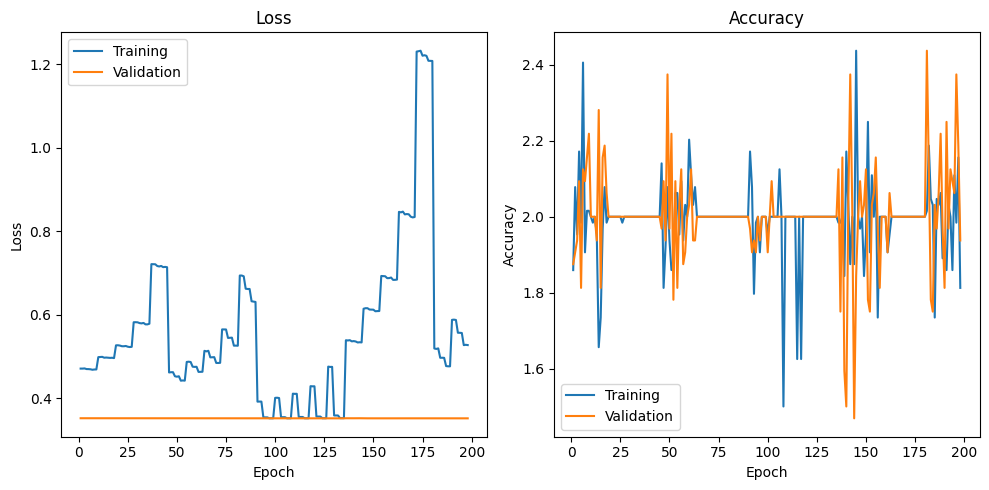

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training')
plt.plot(epochs, test_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training')
plt.plot(epochs, test_accuracies, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()